In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
from scipy.optimize import curve_fit
import matplotlib as mpl
from glob import glob
from copy import copy

%matplotlib widget

In [3]:
def read_dat_file(file_path):
    try:
        with open(file_path, 'r') as file:
            data = [list(map(float, line.split())) for line in file]
            return np.array(data)
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [4]:
s21 = np.load('VNAsweep_s21_5-9GHz.npy')
freqs = np.load('VNAsweep_freqs_5-9GHz.npy')

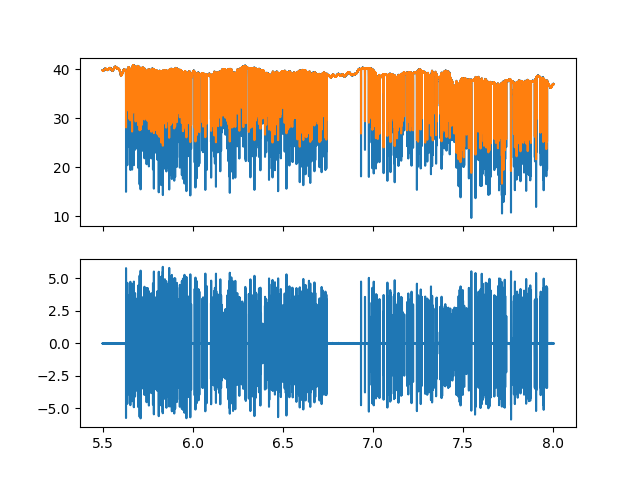

In [5]:
dir = './mapping_20x20/'
dark_s21 = np.load(glob(dir + '*dark.npy')[0])
freqs = np.load(glob(dir + '*freqs.npy')[0])
sw = 4 # even number
mph = 0.05
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='valid')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='valid')
d2s21 = np.diff(smooth_ds21, 1)
offset = len(dark_s21) - len(d2s21)

fig, ax = plt.subplot_mosaic('a;b', sharex=True)
ax['a'].plot(freqs, dark_s21)
ax['a'].plot(freqs[:-(sw-1)], smooth_s21)
ax['b'].plot(freqs[sw-1:-1], ds21)
# ax['a'].plot(freqs[sw-1:], smooth_s21)

398


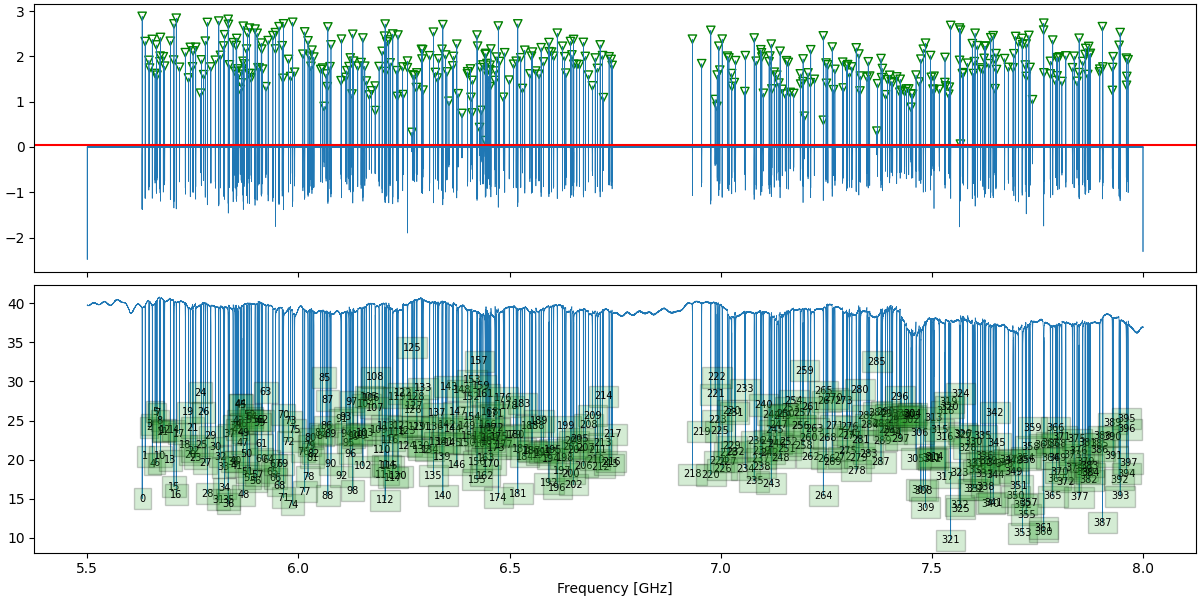

In [6]:
dir = './mapping_20x20/'
dark_s21 = np.load(glob(dir + '*dark.npy')[0])
freqs = np.load(glob(dir + '*freqs.npy')[0])
sw = 4 # even number
mph = 0.05
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
# ax['a'].plot(smooth_ds21)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, dark_s21, lw=.5)
ax['a'].axhline(mph, c='r')
# ax['b'].plot(s21)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']
ax['a'].scatter(freqs[:-2][locs], heights, marker='v', c='None', edgecolor='g')
for i in range(len(locs)):
    ax['b'].text(freqs[:-2][locs[i]], dark_s21[locs[i]], str(i), ha='center', va='center', fontsize=7, bbox=dict(facecolor='tab:green', alpha=0.2))
# ax['b'].scatter(freqs[locs], dark_s21[locs], marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

In [7]:
yfiles = glob(dir + '*x0*.npy')
xfiles = glob(dir + '*y0*.npy')
nr_x = len(xfiles)
nr_y = len(yfiles)
nr_steps = int(np.amax((nr_x, nr_y)))
nr_kids = len(locs)
s21s = np.empty((nr_steps, 2, nr_kids))
s21s[:] = np.nan
s0 = dark_s21[locs]
sx0 = np.load(xfiles[0])[locs]
sy0 = np.load(yfiles[0])[locs]
for i, xfile in enumerate(xfiles):
    if i < len(xfiles):
        s21x = np.load(xfile)
        s21s[i, 0, :]  = s21x[locs] - sx0
    if i < len(yfiles):
        yfile = yfiles[i]
        s21y = np.load(yfile)
        s21s[i, 1, :]  = s21y[locs] - sy0 

In [8]:
sw = 6
dw = 4
medw = 5
mph = .21
mpw = 0
mpp = mph/5
smooth_s21s = np.empty((len(xfiles)+5, 2, len(locs)))
smooth_s21s[:] = np.nan
smooth_d2s21s = np.empty((len(xfiles)+9, 2, len(locs)))
smooth_d2s21s[:] = np.nan
window = np.ones(sw)/sw
dwindow = np.ones(dw)/dw
pos = np.empty((nr_kids, 3))
pos[:] = np.nan
pos[:, 2] = np.arange(nr_kids)
semi_pos = np.empty((nr_kids, 3))
semi_pos[:] = np.nan
semi_pos[:, 2] = np.arange(nr_kids)
nr_good = 0
nr_semi = 0
bad = []
for i in range(nr_kids):
    powerx = s21s[:, 0, i]
    powerx = powerx[~np.isnan(powerx)]
    medpowerx = medfilt(powerx, medw)
    smoothpowerx = convolve(medpowerx, window, mode='full')
    smooth_s21s[:len(smoothpowerx), 0, i] = smoothpowerx
    d1x = np.diff(smoothpowerx, 1)
    d1xsmooth = convolve(d1x, dwindow, mode='full')
    d2x = np.diff(d1xsmooth, 1)
    d2x = convolve(d2x, dwindow, mode='full')
    smooth_d2s21s[:len(d2x), 0, i] = d2x

    powery = s21s[:, 1, i]
    powery = powery[~np.isnan(powery)]
    medpowery = medfilt(powery, medw)
    smoothpowery = convolve(medpowery, window, mode='full')
    smooth_s21s[:len(smoothpowery), 1, i] = smoothpowery
    d1y = np.diff(smoothpowery, 1)
    d1ysmooth = convolve(d1y, dwindow, mode='full')
    d2y = np.diff(d1ysmooth, 1)
    d2y = convolve(d2y, dwindow, mode='full')
    smooth_d2s21s[:len(d2y), 1, i] = d2y
    locx, propx = find_peaks(-d2x, height=mph, prominence=mpp, width=mpw)
    locy, propy = find_peaks(-d2y, height=mph, prominence=mpp, width=mpw)
    
    if len(locx)==1 and len(locy)==1:
        cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)
        cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)
        pos[i, 0] = cx
        pos[i, 1] = cy
        nr_good += 1
    # else:
    #     bad.append(i)
    elif len(locx)==1 or len(locy)==1:
        bad.append(i)
        if len(locx) == 1:
            cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)
            semi_pos[i, 1] = np.nanargmin(d2y)
            semi_pos[i, 0] =  cx
        if len(locy) == 1:
            cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)
            semi_pos[i, 0] = np.nanargmin(d2x)
            semi_pos[i, 1] =  cy
        nr_semi += 1
        # print('one peak at: ', i)
    else:
        bad.append(i)
        pass
        # print('NO peak at: ', i)
print('good: ', nr_good)
# print('semi: ', nr_semi)
print('bad: ', nr_kids - nr_good - nr_semi)

good:  306
bad:  15


C:\Users\wilbertr\AppData\Local\Temp\ipykernel_7544\2873713003.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[i, 0] = cx
C:\Users\wilbertr\AppData\Local\Temp\ipykernel_7544\2873713003.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos[i, 1] = cy
C:\Users\wilbertr\AppData\Local\Temp\ipykernel_7544\2873713003.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  semi_pos[i, 0] =  cx
C:\Users\wilbertr\AppData\Local\Temp\ipykernel_7544\2873713003.py:64: 

ValueError: x and y must have same first dimension, but have shapes (200,) and (0, 3)

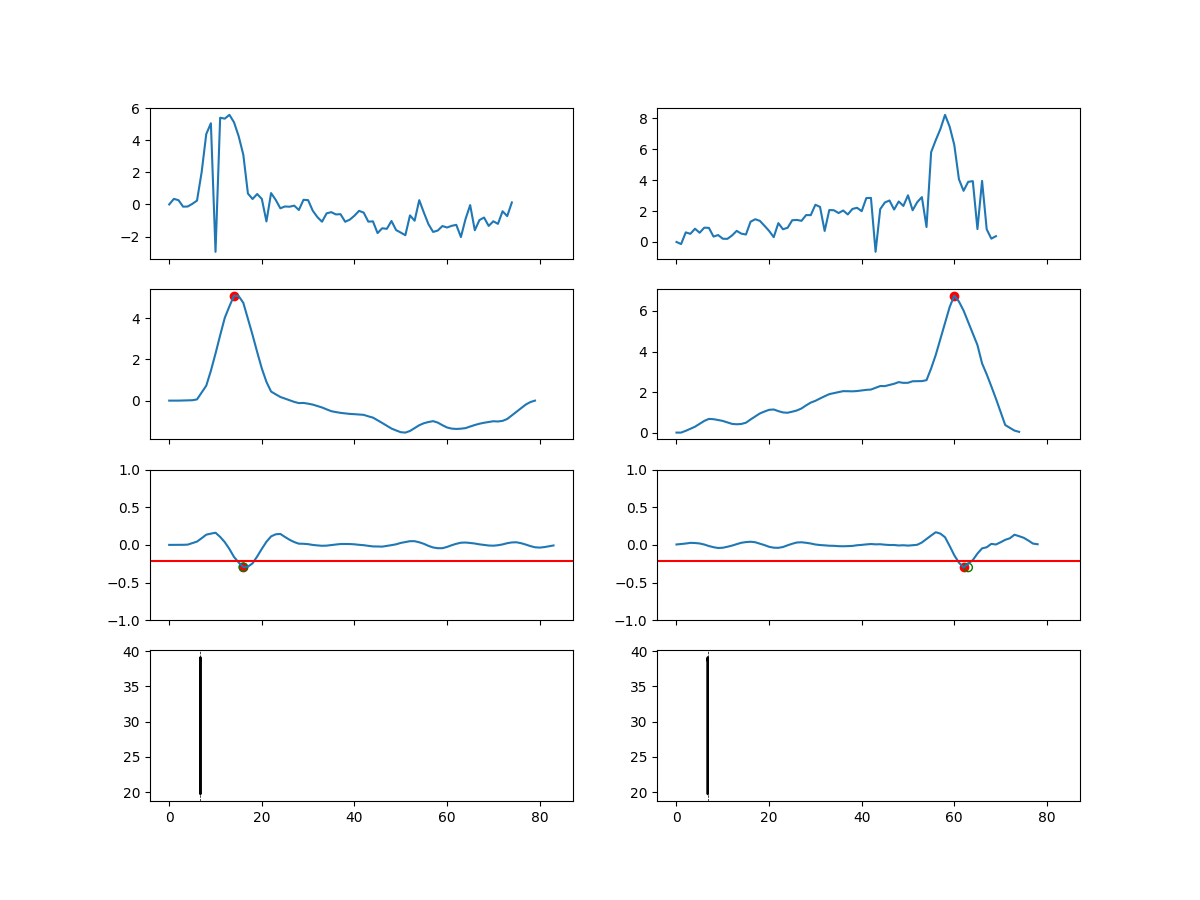

In [9]:
kid = 217
x = s21s[:, 0, kid]
y = s21s[:, 1, kid]
xsmooth = smooth_s21s[:, 0, kid]
ysmooth = smooth_s21s[:, 1, kid]
d2xsmooth = smooth_d2s21s[:, 0, kid]
d2ysmooth = smooth_d2s21s[:, 1, kid]

fig, ax = plt.subplot_mosaic('ab;cd;ef;gh', figsize=(12, 9), sharex=True)
ax['a'].plot(x)
ax['b'].plot(y)

ax['c'].plot(xsmooth)
ax['d'].plot(ysmooth)
ax['c'].scatter(np.nanargmax(xsmooth), np.nanmax(xsmooth), c='r')
ax['d'].scatter(np.nanargmax(ysmooth), np.nanmax(ysmooth), c='r')

ax['e'].plot(d2xsmooth)
ax['f'].plot(d2ysmooth)
ax['e'].axhline(-mph, c='r')
ax['f'].axhline(-mph, c='r')
locx, propx = find_peaks(-d2xsmooth, height=mph, prominence=mpp, width=mpw)
cx = np.round((propx['right_ips'] + propx['left_ips']) / 2)
locy, propy = find_peaks(-d2ysmooth, height=mph, prominence=mpp, width=mpw)
cy = np.round((propy['right_ips'] + propy['left_ips']) / 2)
ax['e'].scatter(locx, -propx['peak_heights'], c='r')
ax['f'].scatter(locy, -propy['peak_heights'], c='r')
ax['e'].set_ylim(-1, 1)
ax['f'].set_ylim(-1, 1)
ax['e'].scatter(cx, -propx['peak_heights'], c='None', edgecolor='g')
ax['f'].scatter(cy, -propy['peak_heights'], c='None', edgecolor='g')
floc = locs[kid]
bw = 100
ax['g'].plot(freqs[floc-bw:floc+bw], dark_s21[floc-bw:floc+bw], c='k')
ax['h'].plot(freqs[floc-bw:floc+bw], dark_s21[floc-bw:floc+bw], c='k')
ax['g'].axvline(freqs[floc], ls='--', lw=.5, c='k')
ax['h'].axvline(freqs[floc], ls='--', lw=.5, c='k')
idx = np.arange(18, 21)
idy = np.arange(21, 25)
ax['g'].set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(idx))))
ax['h'].set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(idy))))
_ = ax['g'].plot(freqs[floc-bw:floc+bw], s21s[idx, 1, floc-bw:floc+bw].T, lw=.5)
_ = ax['h'].plot(freqs[floc-bw:floc+bw], s21s[idy, 1, floc-bw:floc+bw].T, lw=.5)

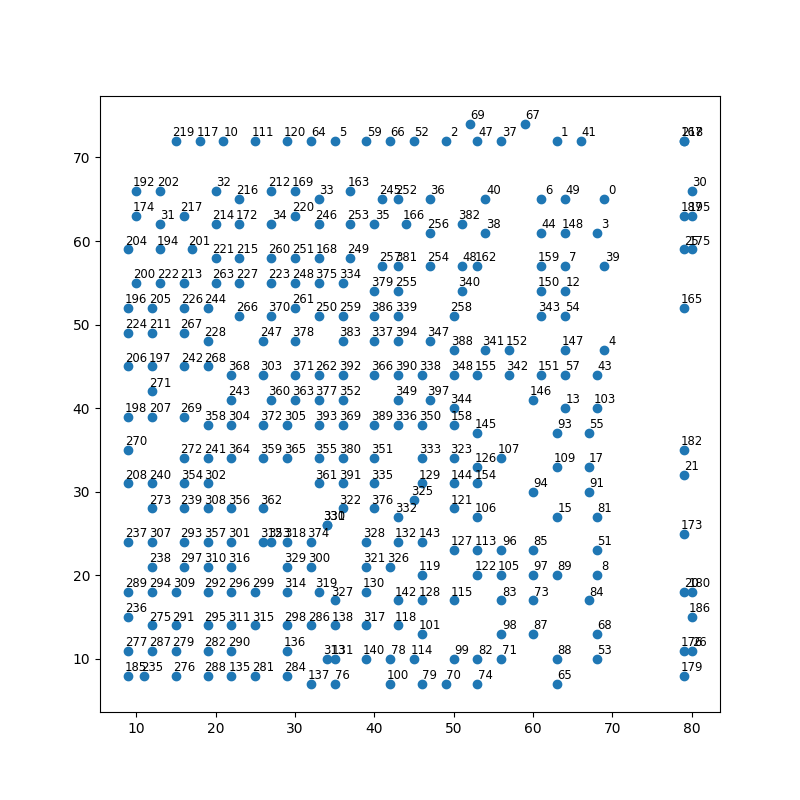

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(*pos[:, :2].T)
for coord in pos:
    if ~np.any(np.isnan(coord)):
        text = ax.text(coord[0]+1, coord[1]+1, str(int(coord[2])), ha="center", va="center", color="k", fontsize='small',zorder=4)  
# ax.scatter(*semi_pos.T, c='None', edgecolor='orange')

In [11]:
kid_id_board = np.load('KID_id_board_400.npy')
kid_id_board -= 1
kid_id_board

array([[  0,   3,  44, 147,  48,   5,  46, 109,  50,   7,  92,  85,  52,
          9,  90,  69,  54,  11,  58,  61],
       [ 43, 148,   1,   4,  45, 146,  49,   6,  93, 108,  51,   8,  91,
         86,  53,  10,  89,  60,  55,  12],
       [  2,  39, 158, 149, 344,  47, 152, 145, 110, 121,  94, 107,  84,
         97,  68,  87,  70,  57,  62,  59],
       [159,  42, 345,  38, 157, 150, 343, 122, 153, 106, 111, 120,  95,
        104,  83,  98,  67,  88,  13,  56],
       [ 40,  37, 160, 387, 346, 341, 156, 151, 144, 123, 154, 105, 112,
        119,  96, 103,  82,  71,  66,  63],
       [161, 386,  41, 340, 255, 388, 349, 342, 155, 324, 143, 118, 125,
        102, 113,  78,  99,  64,  81,  14],
       [ 36, 257, 254, 389, 384, 347, 336, 399, 350, 333, 124, 325, 142,
        117, 126, 101, 114,  79,  72,  65],
       [253, 162, 385, 256, 339, 396, 391, 348, 335, 398, 323, 332, 127,
        326, 141, 116,  77, 100,  15,  80],
       [248,  35, 258, 383, 390, 337, 368, 397, 392, 351, 334, 3

In [12]:
IDs = np.load('LT343_5_mapped_IDs.npy')
coords = np.load('LT343_5_KID_Coordinates.npy')
kids = np.empty((20,20))
kids[:] = np.nan
for i, ID in enumerate(IDs):
    kids[coords[i, 1]-1, coords[i, 0]-1] = ID
kids[kids==392] = np.nan
kids[kids==217] = np.nan
kids[kids==89] = np.nan
# kids[:, -1] = np.nan
# kids[0, :] = np.nan
# kids[-1, :] = np.nan
kids

array([[  0.,   3.,  39., 140.,  45.,   4.,  43., 102.,  55.,  17.,  90.,
         80.,  51.,   8.,  83.,  68.,  53.,   9.,  58.,  41.],
       [ 49., 147.,   7.,  12.,  54., 146.,  57.,  13.,  92., 108.,  60.,
         15.,  91.,  88.,  62.,  14.,  87.,  65.,  61.,   1.],
       [  6.,  44., 158., 149., 341.,  56., 150., 145., 109., 122.,  93.,
        107.,  84.,  96.,  72.,  86.,  71.,  63.,  nan,  46.],
       [155.,  50., 343.,  42., 156., 151., 340., 124., 152., 106., 111.,
        123.,  95., 104.,  82., 101.,  70.,  85.,  16.,  37.],
       [ 40.,  38., 161., 383., 344., 339., 154., 148., 144., 125., 153.,
        105., 112., 121.,  94.,  nan,  81.,  73.,  67.,  47.],
       [160., 380.,  48., 338., 257., 386., 346., 342., 157., 321., 143.,
        120., 126., 103., 114.,  nan,  98.,  nan,  79.,   2.],
       [ 36., 255.,  nan, 385., 382., 345., 336., 395., 348., 331., 128.,
        330., 142., 118., 127., 100., 113.,  78.,  74.,  52.],
       [251., 165., 379., 254., 337., 394

In [ ]:
Qs = np.load('dQc_fit_LT343.npy')+50e3
Qs_design = np.load('LT343_FAB_Qs.npy')
Qmap = np.empty((20,20))
Qmap[:] = np.nan
Qmap_design = np.empty((20,20))
Qmap_design[:] = np.nan
for i, Q in enumerate(Qs):
    Qmap[coords[i, 1]-1, coords[i, 0]-1] = Q
    Qmap_design[coords[i, 1]-1, coords[i, 0]-1] = Qs_design[i]
Qmap

In [17]:
M_pxs = 20
N_pxs = 20
mask = (kids == kid_id_board)
nr_tot = (M_pxs*N_pxs)
nr_detected = len(kids[~np.isnan(kids)])
nr_notswapped = np.sum(mask)
nr_identified = np.sum(~np.isnan(kids))
nr_swapped = nr_identified - nr_notswapped
same = np.argwhere(mask)
f0s_design = np.load('LT343_FAB_F0s.npy')
f0s = np.load('LT343_5_f0_measured.npy')*1e9

In [18]:
f0s_mapped = np.empty(f0s_design.shape)
f0s_mapped[:] = np.nan
Qs_mapped = np.empty(f0s_design.shape)
Qs_mapped[:] = np.nan
df_f = np.empty(kids.shape)
df_f[:] = np.nan
df = np.empty(kids.shape)
df[:] = np.nan
mapped_spacings = np.empty(kids.shape)
mapped_spacings[:] = np.nan
for i in range(M_pxs):
    for j in range(N_pxs):
        design_kid = kid_id_board[i, j]
        design_f0_idx = design_kid
        design_f0 = f0s_design[design_f0_idx]
        mapped_kid = kids[i, j]
        Q_mapped_kid = Qmap[i, j]
        if ~np.isnan(Q_mapped_kid):
            Qs_mapped[design_kid] = Q_mapped_kid
        if ~np.isnan(mapped_kid):
            mapped_f0_idx = mapped_kid
            mapped_f0_idx = int(mapped_f0_idx)
            mapped_f0 = f0s[mapped_f0_idx]
            f0s_mapped[design_kid] = mapped_f0
            df[i, j] = (design_f0 - mapped_f0)
            df_f[i, j] = df[i, j] / design_f0
            if design_kid > 1:
                prev_design_kid = design_kid - 1
                prev_i, prev_j = np.argwhere(kid_id_board==prev_design_kid)[0]
                prev_mapped_kid = kids[prev_i, prev_j]
                if ~np.isnan(prev_mapped_kid):
                    prev_mapped_f0_idx = prev_mapped_kid - 1
                    prev_mapped_f0_idx = int(prev_mapped_f0_idx)
                    prev_mapped_f0 = f0s[prev_mapped_f0_idx]
                    mapped_spacings[i, j] = mapped_f0 - prev_mapped_f0
std_df_f = np.std(df_f[~np.isnan(df_f)])
print(std_df_f)

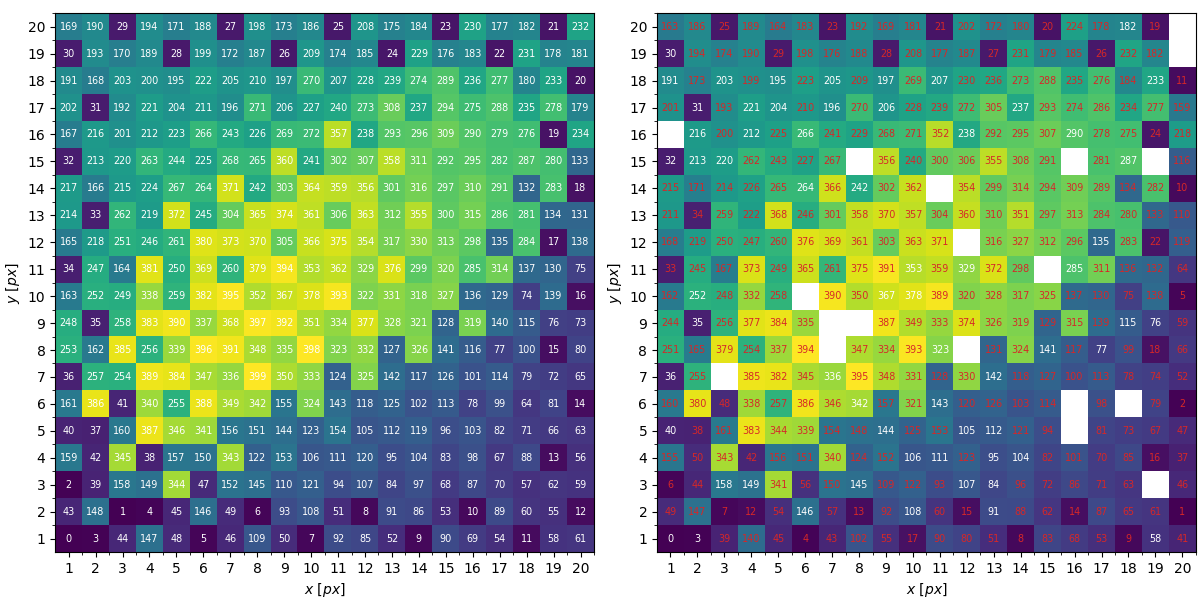

In [21]:
fig, ax = plt.subplot_mosaic('ba', figsize=(12, 6), constrained_layout=True)

############################
ax['a'].imshow(kids, origin='lower', cmap='viridis')
for i in range(M_pxs):
    for j in range(N_pxs):
        idx = kids[i, j]
        if ~np.isnan(idx):
            if mask[i, j]:
                color = 'w'
            else:
                color = 'tab:red'
            text = ax['a'].text(j, i, '%d' % idx, ha="center", va="center", color=color, fontsize='x-small') 
# Major ticks
ax['a'].set_xticks(np.arange(0, M_pxs, 1));
ax['a'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['a'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['a'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['a'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['a'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['a'].set_xlabel('$\it x$ $[px]$')
ax['a'].set_ylabel('$\it y$ $[px]$')
# ax['a'].set_title("Measurement")
# grid
ax['a'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['a'].grid(False, which='major')

############################
im = ax['b'].imshow(kid_id_board, origin='lower', cmap='viridis')
for i in range(M_pxs):
    for j in range(N_pxs):
        idx = kid_id_board[i, j]
        if ~np.isnan(idx):
            text = ax['b'].text(j, i, '%d' % idx, ha="center", va="center", color="w", fontsize='x-small')   
# Major ticks
ax['b'].set_xticks(np.arange(0, M_pxs, 1));
ax['b'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['b'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['b'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['b'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['b'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['b'].set_xlabel('$\it x$ $[px]$')
ax['b'].set_ylabel('$\it y$ $[px]$')
# ax['b'].set_title("Design")
# grid
ax['b'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['b'].grid(False, which='major')
# cbar = fig.colorbar(im, ax=ax['b'])
# # cbar.ax.invert_yaxis()
# cbar.ax.set_ylabel('$f_0$ $[GHz]$')




In [22]:
f0s[217]
print(f0s_design[232])

7311576860.400003


# detected: 381/400
# identified: 381/381
# swapped: 318/381 


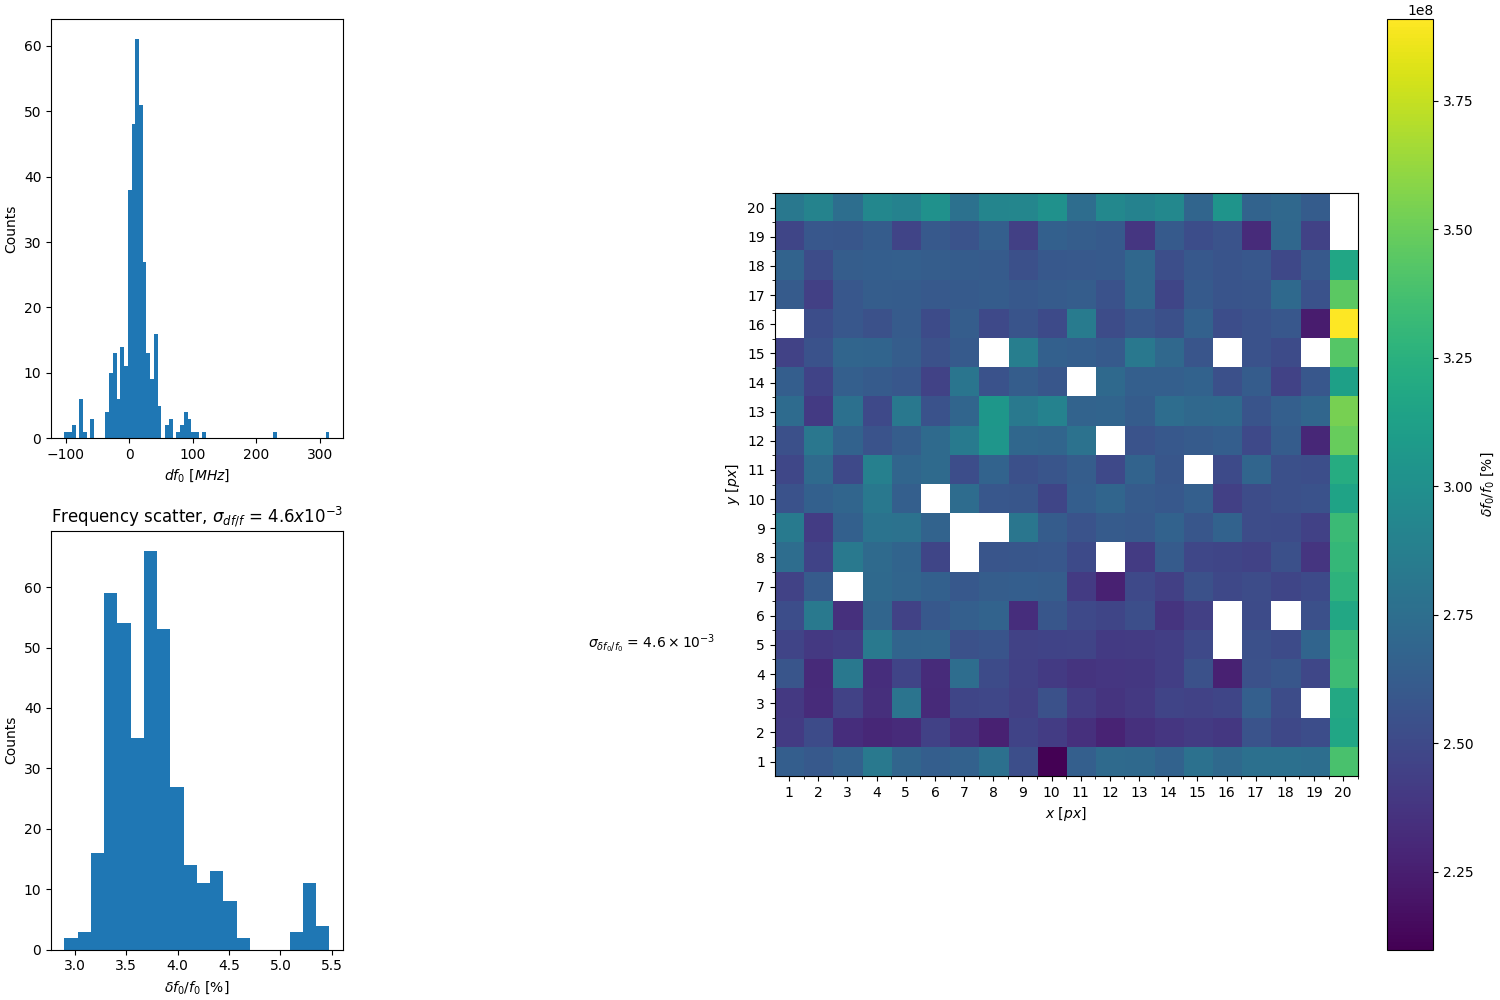

In [23]:
fig, ax = plt.subplot_mosaic('hcc;fcc', figsize=(15, 10), constrained_layout=True)

###################################
# ax['h'].hist(spacings*1e-6, bins=50, alpha=.8, label='before')
ax['h'].hist(mapped_spacings.flatten()*1e-6, bins='auto', alpha=1, label='after')
# ax['h'].set_xlim([-100, 100])
# ax['h'].set_ylim([0, 50])
ax['h'].set_xlabel('$d\it{f_0}$ $[MHz]$')
ax['h'].set_ylabel('Counts')

###################################
ax['f'].hist((df_f.flatten()*100), bins='auto')
ax['f'].text(8, 50, "$\it\sigma_{\delta f_0/f_0}$ = $%.1f \\times 10^{-3}$" % (std_df_f*1e3))
# ax['f'].set_xlim((7, 11))
ax['f'].set_xlabel('$\it \delta f_0/f_0$ [%]')
ax['f'].set_ylabel('Counts')
# ax['f'].set_ylim([0, 60])
ax['f'].set_title("Frequency scatter, $\it\sigma_{df/f}$ = $%.1f x 10^{-3}$" % (std_df_f*1e3))
# ax['f'].legend()
print('# detected: %d/%d\n# identified: %d/%d\n# swapped: %d/%d ' % (nr_detected, nr_tot, nr_identified, nr_detected, nr_swapped, nr_identified))

###################################
im = ax['c'].imshow(df, origin='lower', cmap='viridis')
# Major ticks
ax['c'].set_xticks(np.arange(0, M_pxs, 1));
ax['c'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['c'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# Minor ticks
ax['c'].set_xticks(np.arange(0.5, M_pxs, 1), minor=True);
ax['c'].set_yticks(np.arange(0.5, N_pxs, 1), minor=True);
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
# ax['c'].set_title("$\it\sigma_{df/f}$ = $%.1f x 10^{-3}$" % (std_df_f*1e3))
# grid
ax['c'].grid(True, which='minor', color='None', linestyle='-', linewidth=0.5)
ax['c'].grid(False, which='major')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it \delta f_0/f_0$ [%]')
# print('Unidentified: \n', newhidden_pks)
# plt.savefig('scatter.svg')

line


C:\Users\wilbertr\AppData\Local\Temp\ipykernel_7544\2954750391.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(line, f0s_design[~nans], f0s_mapped[~nans])


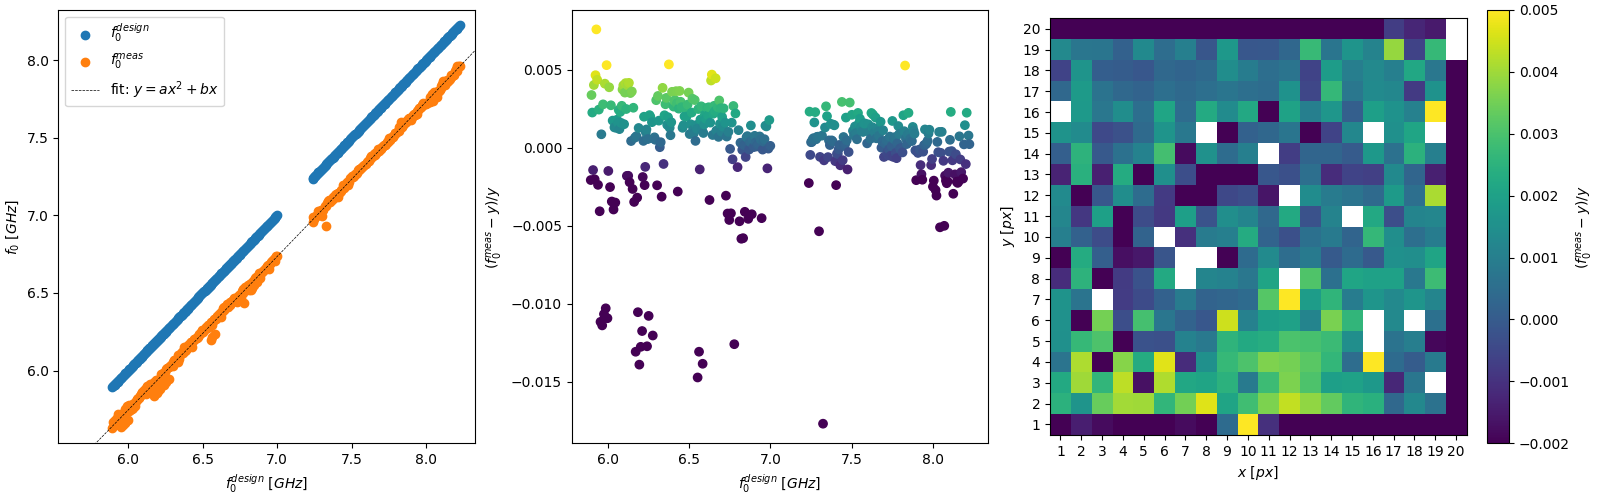

In [24]:
def linear(x, a):
    return a*x

def secorder(x, a, b, c):
    return a*x**2+b*x

def thirdorder(x, a, b, c):
    return a*x**3+b*x**2+c*x

def fourthorder(x, a, b, c, d):
    return a*x**4+b*x**3+c*x**2+d*x


ids = np.arange(400)
nans = np.isnan(f0s_mapped)

line = secorder
flim = np.array([np.amin((f0s_design[~nans], f0s_mapped[~nans]))-.1e9, np.amax((f0s_design[~nans], f0s_mapped[~nans]))+.1e9])
if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    elif line == thirdorder:
        eq = 'y=ax^3+bx^2+cx'
        save = 'fit_thirdorder'
    elif line == fourthorder:
        eq = 'y=ax^4+bx^3+cx^2+dx'
        save = 'fit_fourthorder'
    print('line')
    popt, pcov = curve_fit(line, f0s_design[~nans], f0s_mapped[~nans])
    fit = line(f0s_design, *popt)
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    fit = f0s_design
    label = 'f_0^{design}'
    save = 'nofit'


corr_df = (f0s_mapped-fit)
corr_df_f = corr_df / fit
corr_df_map = np.empty(kids.shape)
corr_df_map[:] = np.nan
corr_df_f_map = np.empty(kids.shape)
corr_df_f_map[:] = np.nan
for i, val in enumerate(corr_df):
    x, y = np.argwhere(kid_id_board==i)[0]
    corr_df_map[x, y] = val
    corr_df_f_map[x, y] = corr_df_f[i]

fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(f0s_design*1e-9, f0s_design*1e-9, label='$\it f_0^{design}$')
ax['a'].scatter(f0s_design*1e-9, f0s_mapped*1e-9, label='$\it f_0^{meas}$')
if line:
    ax['a'].plot(xfit*1e-9, yfit*1e-9, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim*1e-9)
ax['a'].set_ylim(flim*1e-9)
ax['a'].legend(loc='upper left')
clim = [-0.002, 0.005]
ax['b'].scatter(f0s_design*1e-9, corr_df_f, label='residual, $f_0-y_2$', c=corr_df_f, vmin=clim[0], vmax=clim[1])
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(corr_df_f_map, origin='lower', cmap='viridis', vmin=clim[0], vmax=clim[1])
# Major ticks
ax['c'].set_xticks(np.arange(0, M_pxs, 1));
ax['c'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['c'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
# ax['c'].set_ylim([-100, 50])
# plt.savefig('LT343chip5_scatter_'+save)

In [25]:
np.std(corr_df_f[(corr_df_f >-.005) & (corr_df_f < 0.001)])

0.0014733749656884914

In [26]:
ctr = corr_df_f_map[1:-1, :-1]
np.std(ctr[~np.isnan(ctr)])

0.0016249269239514497

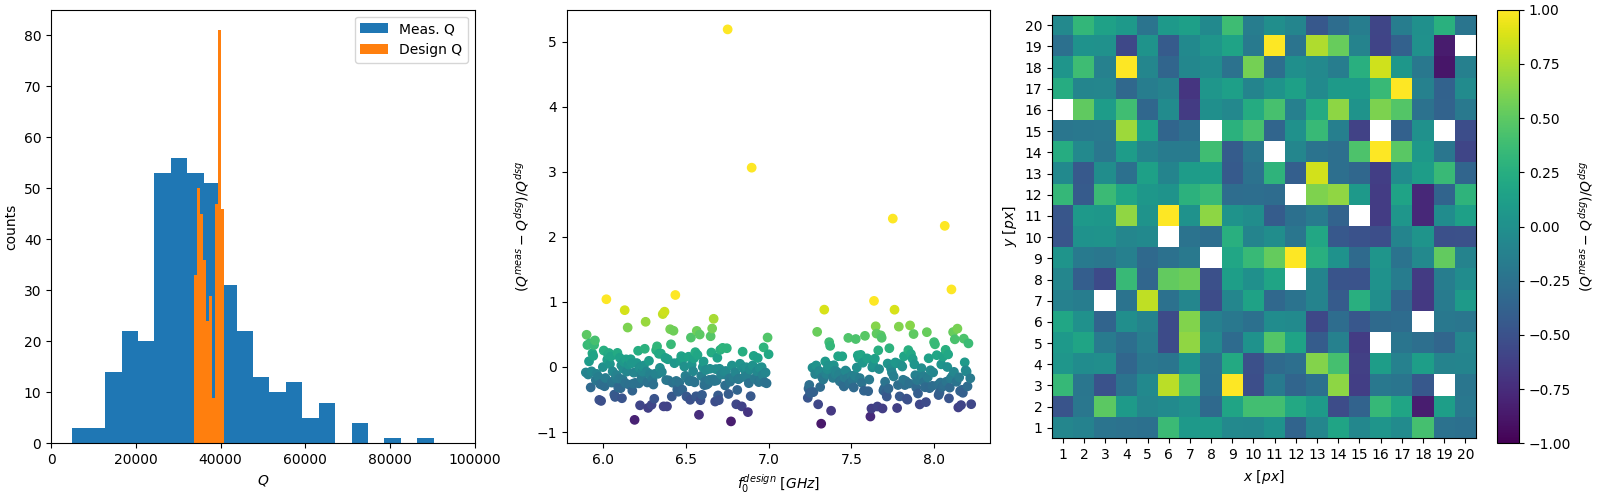

In [27]:
dQ_Q = (Qs_mapped-Qs_design)/Qs_design
dQmap_Q = (Qmap-Qmap_design)/Qmap_design
clim = [-1, 1]
fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
_ = ax['a'].hist(Qs, bins='auto', label='Meas. Q')
_ = ax['a'].hist(Qs_design, bins='auto', label='Design Q')
# _ = ax['a'].axvline(50e3, c='k', ls='--', label='Design Q')
ax['a'].set_xlabel('$\it Q$')
ax['a'].set_ylabel('counts')
ax['a'].set_xlim([0, 1e5])
ax['a'].legend(loc='upper right')
# ax['d'].scatter(Qs_design, Qs_mapped)
ax['b'].scatter(f0s_design*1e-9, dQ_Q, c=dQ_Q, vmin=clim[0], vmax=clim[1])
ax['b'].set_ylabel('$\it (Q^{meas}-Q^{dsg})/Q^{dsg}$')
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(dQmap_Q, origin='lower', cmap='viridis', vmin=clim[0], vmax=clim[1])
# Major ticks
ax['c'].set_xticks(np.arange(0, M_pxs, 1));
ax['c'].set_yticks(np.arange(0, N_pxs, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, M_pxs+1, 1));
ax['c'].set_yticklabels(np.arange(1, N_pxs+1, 1));
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (Q^{meas}-Q^{dsg})/Q^{dsg}$')

Text(0, 0.5, 'Q-scatter')

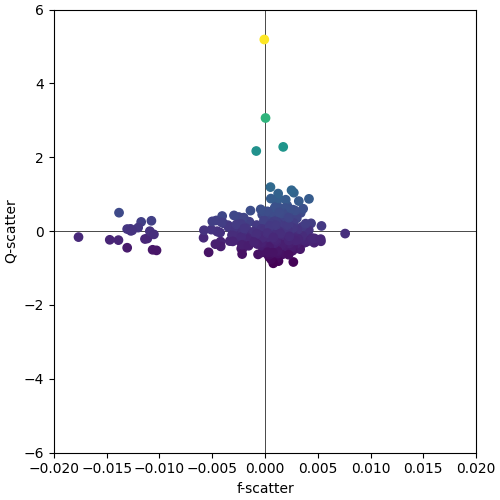

In [28]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.axvline(0, lw=.5, c='k')
ax.axhline(0, lw=.5, c='k')
ax.scatter(corr_df_f, dQ_Q, c=dQ_Q, zorder=2)
ax.set_xlim([-.02, .02])
ax.set_ylim([-6, 6])
ax.set_xlabel('f-scatter')
ax.set_ylabel('Q-scatter')


Text(0, 0.5, 'Q-scatter')

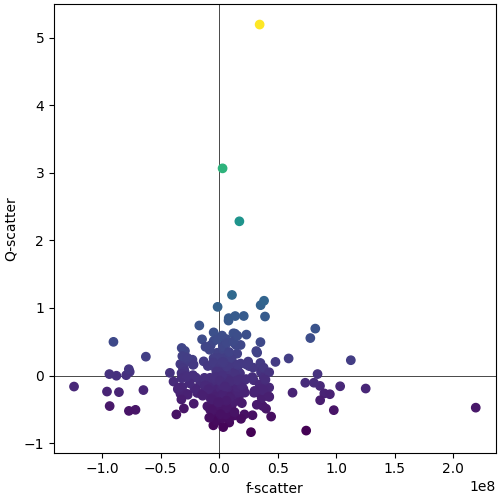

In [29]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.axvline(0, lw=.5, c='k')
ax.axhline(0, lw=.5, c='k')
ax.scatter(f0s_mapped[1:]-f0s_mapped[:-1], dQ_Q[1:], c=dQ_Q[1:], zorder=2)
# ax.set_xlim([-.02, .02])
# ax.set_ylim([-6, 6])
ax.set_xlabel('f-scatter')
ax.set_ylabel('Q-scatter')